#### Download Dataset

In [2]:
import os
import pandas

#Download and save to Disk
if os.path.exists('green_tripdata_2015-09.csv'): 
    data = pandas.read_csv('green_tripdata_2015-09.csv')
else: 
    url = "https://s3.amazonaws.com/nyc-tlc/trip+data/green_tripdata_2015-09.csv"
    data = pandas.read_csv(url)
    data.to_csv(url.split('/')[-1])

print ("Number of rows:", data.shape[0])
print ("Number of columns: ", data.shape[1]-1) #it adds one index column automatically

Number of rows: 1494926
Number of columns:  21


#### Number of rows: 1494926
#### Number of columns:  21

In [3]:
print("Median:",data.Trip_distance.median())
print("Mean:",data.Trip_distance.mean())
print("Max Trip Distance:",data.Trip_distance.max())
print("Min Trip Distance:",data.Trip_distance.min())
print("Standard Deviation:",data.Trip_distance.std())

Median: 1.98
Mean: 2.9681408511189864
Max Trip Distance: 603.1
Min Trip Distance: 0.0
Standard Deviation: 3.076620809361319


##### From mean we can see that maximum value is an outlier. And 603 miles on Taxi does not make much sense as well.

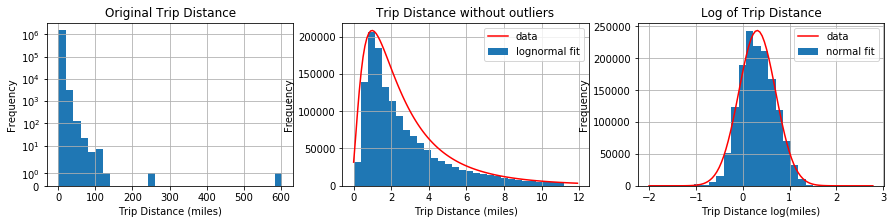

In [24]:
import matplotlib.pyplot as plot
from scipy.stats import lognorm,norm
import numpy

fig,ax = plot.subplots(1,3,figsize = (15,3)) 

data.Trip_distance.hist(bins=30,ax=ax[0])
ax[0].set_xlabel('Trip Distance (miles)')
ax[0].set_ylabel('Frequency')
ax[0].set_yscale('symlog')
ax[0].set_title('Original Trip Distance')

trip_Distance_ = data.Trip_distance 
median_Trip_Distance_=trip_Distance_.median()
std_Trip_Distance_=trip_Distance_.std()

#Remove data more than 3 standard deviation apart
#Data also contains trips with 0 distance so remove those trips as well

trip_Distance_=data.Trip_distance[data.Trip_distance>0]
trip_Distance_ = trip_Distance_[(trip_Distance_-median_Trip_Distance_).abs()<3*std_Trip_Distance_]


trip_Distance_.hist(bins=30,ax=ax[1]) # 
ax[1].set_xlabel('Trip Distance (miles)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Trip Distance without outliers')

# apply a lognormal fit. Use the mean of trip distance as the scale parameter
shape, location, scale = lognorm.fit(data.Trip_distance.values,
                               scale=data.Trip_distance.mean(),
                               loc=0)
pdf_LogNormal = lognorm.pdf(numpy.arange(0,12,.1),shape,location,scale)
ax[1].plot(numpy.arange(0,12,.1),710000*pdf_LogNormal,'r') 
ax[1].legend(['data','lognormal fit'])

#Remove zeros because log of 0 is undefined
data_Trip_Filtered=data.Trip_distance[data.Trip_distance>0]
normal_Dist=numpy.log10(data_Trip_Filtered)
normal_Dist.hist(bins=30,ax=ax[2])
ax[2].set_xlabel('Trip Distance log(miles)')
ax[2].set_ylabel('Frequency')
ax[2].set_title('Log of Trip Distance')
mu, std = norm.fit(normal_Dist)
x=numpy.linspace(min(normal_Dist), max(normal_Dist), 100)
pdf_Normal = norm.pdf(x,mu,std)
ax[2].plot(x,240000*pdf_Normal,'r') 
ax[2].legend(['data','normal fit'])
plot.show()

The median of Trip Distance (1.98) is smaller than its mean (2.96) and and standard deviation is 3.07. The distribution is asymmetric and skewed towards right therefore, it has a structure of a lognormal distribution. The reason for that is because trip distance cannot be negative. 

Figure on the left shows the original distribution of Trip distance. Frequency of original is in log scale to make the distribution more visible. The figure in the middle is the one without outliers (any point more than 3 standard deviations from the median). The figure on the right is a log of lognormal distribution which is Gaussian distribution which also proves our hypothesis that the Trip distance is lognormally distributed.


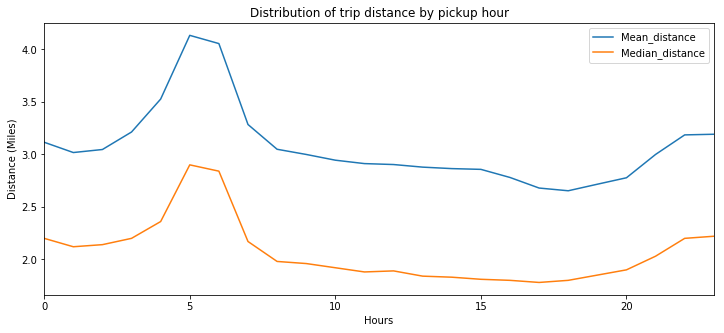

  Hour    Mean distance    Median distance
------  ---------------  -----------------
     0          3.11528               2.2
     1          3.01735               2.12
     2          3.04618               2.14
     3          3.21295               2.2
     4          3.52656               2.36
     5          4.13347               2.9
     6          4.05515               2.84
     7          3.28439               2.17
     8          3.04845               1.98
     9          2.99911               1.96
    10          2.94448               1.92
    11          2.91202               1.88
    12          2.90306               1.89
    13          2.87829               1.84
    14          2.8643                1.83
    15          2.85704               1.81
    16          2.77985               1.8
    17          2.67911               1.78
    18          2.65322               1.8
    19          2.7156                1.85
    20          2.77705               1.9
    21          2

In [5]:
import datetime as dt
from tabulate import tabulate 

data['lpep_pickup_datetime'] = data.lpep_pickup_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Lpep_dropoff_datetime'] = data.Lpep_dropoff_datetime.apply(lambda x:dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
data['Pickup_hour'] = data.lpep_pickup_datetime.apply(lambda x:x.hour)

fig,ax = plot.subplots(1,1,figsize=(12,5))
table1 = data.pivot_table(index='Pickup_hour', values='Trip_distance',aggfunc=('mean','median')).reset_index()
table1.columns = ['Hour','Mean_distance','Median_distance']
table1[['Mean_distance','Median_distance']].plot(ax=ax)
plot.ylabel('Distance (Miles)')
plot.xlabel('Hours')
plot.title('Distribution of trip distance by pickup hour')
plot.xlim([0,23])
plot.show()
print (tabulate(table1.values.tolist(),["Hour","Mean distance","Median distance"]))

From trip distance per hour, we can observe that the trips early morning and late nights are longer. I would say that is because the traffic is less in early mornings and late nights and therefore, people prefer to take a taxi. And during rush hours, people might be taking subway to avoid traffic.

In [6]:
from shapely.geometry import Point,Polygon,MultiPoint,MultiPolygon
# data points that define the boundary of JFK
jfk = [(40.623310, -73.770609),(40.645649, -73.752899),(40.670122, -73.805965),
              (40.651686, -73.821578)]
lga = [(40.782595, -73.878086),(40.772933, -73.889572),(40.765521, -73.887512),
       (40.766877, -73.863797),(40.771953, -73.855205)]
ewr = [(40.711074, -74.178974),(40.705902, -74.150627),(40.664361, -74.183175),(40.677358, -74.197466)]

poi = Polygon(jfk)
# Function to check if a location is located inside the boundary of JFK
def is_within_bbox(loc,poi=poi):
    return 1*(Point(loc).within(poi))

#Creating two JFK Variables
data['is_JFK_PickUp'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)
data['is_JFK_DropOff'] = data[['Dropoff_latitude','Dropoff_longitude']].apply(lambda r:is_within_bbox((r[0],r[1])),axis=1)

poi = Polygon(lga)
# Function to check if a location is located inside the boundary of JFK
def is_within_bbox_lga(loc,poi=poi):
    return 1*(Point(loc).within(poi))

#Creating two LaGuadia Airport Variables
data['is_LGA_PickUp'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox_lga((r[0],r[1])),axis=1)
data['is_LGA_DropOff'] = data[['Dropoff_latitude','Dropoff_longitude']].apply(lambda r:is_within_bbox_lga((r[0],r[1])),axis=1)

poi = Polygon(ewr)
# Function to check if a location is located inside the boundary of JFK
def is_within_bbox_ewr(loc,poi=poi):
    return 1*(Point(loc).within(poi))

#Creating two Newark Airport Variables
data['is_EWR_PickUp'] = data[['Pickup_latitude','Pickup_longitude']].apply(lambda r:is_within_bbox_ewr((r[0],r[1])),axis=1)
data['is_EWR_DropOff'] = data[['Dropoff_latitude','Dropoff_longitude']].apply(lambda r:is_within_bbox_ewr((r[0],r[1])),axis=1)



In [7]:
Airport_Data=data[(data.is_JFK_PickUp>0) | (data.is_JFK_DropOff>0) | (data.is_LGA_PickUp>0) | 
              (data.is_LGA_DropOff>0) | (data.is_EWR_PickUp>0) | (data.is_EWR_DropOff>0)]

print ("Number of trips to/from Airports: ", Airport_Data.shape[0])
print ("Mean of Airport trips:", Airport_Data.Trip_distance.mean())
print ("Average fare of Airport trips: $", Airport_Data.Fare_amount.mean())
print ("Average total charged amount: $", Airport_Data.Total_amount.mean())

Number of trips to/from Airports:  39504
Mean of Airport trips: 8.793314094775136
Average fare of Airport trips: $ 28.1641816018631
Average total charged amount: $ 34.11966610977355


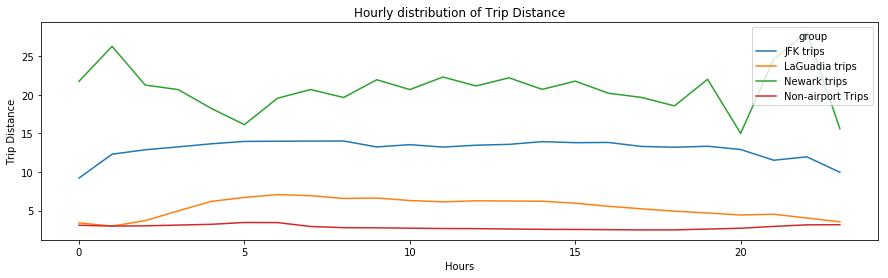

In [98]:
jfk_Data=data[(data.is_JFK_PickUp>0) | (data.is_JFK_DropOff>0)]
lga_Data=data[(data.is_LGA_PickUp>0) | (data.is_LGA_DropOff>0)]
ewr_Data=data[(data.is_EWR_PickUp>0) | (data.is_EWR_DropOff>0)]
nonAirport_Data=data.loc[~data.index.isin(jfk_Data.index)]
nonAirport_Data=nonAirport_Data[~nonAirport_Data.index.isin(lga_Data.index)]
nonAirport_Data=nonAirport_Data[~nonAirport_Data.index.isin(ewr_Data.index)]
jfk_Distance=jfk_Data.groupby('Pickup_hour')['Trip_distance'].mean().reset_index()
lga_Distance=lga_Data.groupby('Pickup_hour')['Trip_distance'].mean().reset_index()
ewr_Distance=ewr_Data.groupby('Pickup_hour')['Trip_distance'].mean().reset_index()
nonAirport_Distance=nonAirport_Data.groupby('Pickup_hour')['Trip_distance'].mean().reset_index()

fig,ax = plot.subplots(1,1,figsize = (15,4))
plot.plot(jfk_Distance.Pickup_hour,jfk_Distance.Trip_distance)
plot.plot(lga_Distance.Pickup_hour,lga_Distance.Trip_distance)
plot.plot(ewr_Distance.Pickup_hour,ewr_Distance.Trip_distance)
plot.plot(nonAirport_Distance.Pickup_hour,nonAirport_Distance.Trip_distance)
plot.xlabel('Hours')
plot.ylabel('Trip Distance')
plot.title('Hourly distribution of Trip Distance')
plot.legend(['JFK trips','LaGuadia trips','Newark trips','Non-airport Trips'],loc='best',title='group')
plot.show()

From the Google Maps, I constructed the polygons around the three New York Airports: John F. Kennedy International (JFK), LaGuardia (LGA) and Newark (EWR). If the data point lies within one of the polygon then that trip was to the airport. The average trip distance to/from airports is much higher (8.79 miles) than the normal average (2.96 miles) which is a reasonable expectation because people usually take cab to airports and airports are usually on the outskirts of the city and therefore, it requires more commute. The average of trips to/from JFK is the highest, around 13.5 miles because it is the major NYC airport and people from all over the city go there especially for international travel even if other airport is near to their home because JFK serves most of the international travels. Secondly, LaGuardia is the closest airport from the main city. It is just 8.6 miles from LaGuardia to Midtown Manhattan, compared to 14.7 miles from JFK and 16.6 miles from Newark, which also explains the figure above.

#### Now I will build a predictive model for tip as a percentage of the total fare. 

First, we have to clean the data because minimum amount to be paid for NYC taxi is $2.5 and also we have to remove the trips with zero duration, also we have to take the absolute values because some values are negative.

### Data Cleaning

In [25]:
data['Trip_type '] = data['Trip_type '].replace(numpy.NaN,1)
data.Total_amount = data.Total_amount.abs()
data.Fare_amount = data.Fare_amount.abs()
data.improvement_surcharge = data.improvement_surcharge.abs()
data.Tip_amount = data.Tip_amount.abs()
data.Tolls_amount = data.Tolls_amount.abs()
data.MTA_tax = data.MTA_tax.abs()
indices = data[~((data.RateCodeID>=1) & (data.RateCodeID<=6))].index
data.loc[indices, 'RateCodeID'] = 2 
indices = data[~((data.Extra==0) | (data.Extra==0.5) | (data.Extra==1))].index
data.loc[indices, 'Extra'] = 0 
data['Trip_duration'] = ((data.Lpep_dropoff_datetime-data.lpep_pickup_datetime).apply(lambda x:x.total_seconds()/60.))
data['is_Tip']=numpy.where(data['Tip_amount']>0, 1, 0)
data['Week'] = (data.lpep_pickup_datetime.apply(lambda x:x.isocalendar()[1])-dt.datetime(2015,9,1).isocalendar()[1])+1
data['Week_day']  = data.lpep_pickup_datetime.apply(lambda x:x.isocalendar()[2])
data['Month_day'] = data.lpep_pickup_datetime.apply(lambda x:x.day)
data['Hour'] = data.lpep_pickup_datetime.apply(lambda x:x.hour)
data = data[(data.Total_amount>=2.5)]
data = data[(data.Trip_duration>0)]

#### Creating Tip Percentage Variable

In [99]:
data['Tip_percentage'] = 100*data.Tip_amount/data.Total_amount
print ("Average Tip percentage - All Transaction:",data.Tip_percentage.mean())
print ("Average Tip percentage - Transactions with Tip:",data[data.is_Tip>0].Tip_percentage.mean())


Average Tip percentage - All Transaction: 6.659577543026192
Average Tip percentage - Transactions with Tip: 16.455194861180285


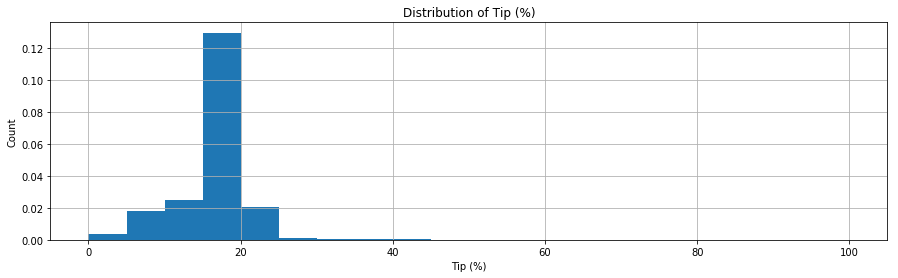

In [39]:
data1 = data[data.Tip_percentage>0]

fig,ax = plot.subplots(1,1,figsize = (15,4))
data1.Tip_percentage.hist(bins = 20,normed=True,ax=ax)
plot.xlabel('Tip (%)')
plot.title('Distribution of Tip (%)')
plot.ylabel('Count')
plot.show()

The average Tip for the transactions with Tip is around 17% which is around a standard tip range.

#### Classification & Regression Analysis

I am going to do two analysis, one is to predict if the Tip is going to be paid or not and the second is to predict the Tip percentage. For the first analysis, I am using Decision Tree Classifier to predict if the tip is going to be paid and to predict the Tip percentage, my regression model will be using Random Forest.

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

features=['Payment_type','Total_amount','Trip_distance','MTA_tax','Extra','Hour']
X=data[features]
Y = data["is_Tip"]
pred_train, pred_test, tar_train, tar_test  =   train_test_split(X, Y, test_size=.3)
classifier=DecisionTreeClassifier()
classifier=classifier.fit(pred_train,tar_train)
predictions=classifier.predict(pred_test)
confusion_matrix(tar_test,predictions)
accuracy_score(tar_test, predictions)

0.94924700952653818

We can see that using Decision Tree on Payment_type, Total_amount, Trip_distance, MTA_tax, Extra, Hour, we can predict with around 95% accuracy if the Tip is going to be paid or not. I saw that the highest correlation to is_Tip was with Payment_type and using only Payment_type, we can predict with 93% accuracy.

#### Regression Model

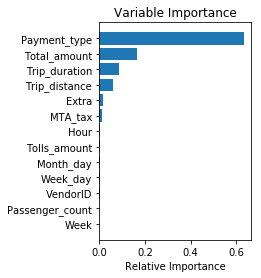

In [100]:
from sklearn.ensemble import RandomForestRegressor
features = ['VendorID', 'Passenger_count', 'Trip_distance', 'Total_amount', 
              'Extra', 'MTA_tax', 'Tolls_amount', 'Payment_type', 
              'Hour', 'Week', 'Week_day', 'Month_day',
              'Trip_duration']
X=data[features]
Y=data['Tip_percentage']
train_x, test_x, train_y, test_y  =   train_test_split(X, Y, test_size=.3)
trained_model = RandomForestRegressor()
trained_model.fit(train_x, train_y)
feature_importance=trained_model.feature_importances_
features = numpy.asarray(features)
sorted_idx = numpy.argsort(feature_importance)
pos = numpy.arange(sorted_idx.shape[0]) 
plot.subplot(1, 2, 2)
plot.barh(pos, feature_importance[sorted_idx], align='center')
plot.yticks(pos, features[sorted_idx])
plot.xlabel('Relative Importance')
plot.title('Variable Importance')
plot.show()

In [43]:
from sklearn import metrics
y_rf = trained_model.predict(test_x)
print ("Mean Squared Error:", metrics.mean_squared_error(y_rf,test_y))
print ("R Square Score:", metrics.r2_score(y_rf,test_y))

Mean Squared Error: 3.63284733745
R Square Score: 0.95180863475


From the Feature Importance graph, we can see that Payment_Type, Total amount, Tip duration and distance are the most important features for Tip. The mean square error and high R square score shows that our tip predictor is reasonable.

#### Now I will derive variable representing the average speed over the course of a trip.

In [48]:
data=data[data.Trip_duration>0]
data['Speed_mph'] = data.Trip_distance/(data.Trip_duration/60)
week_Speed=data.groupby('Week')['Speed_mph'].mean()
hour_Speed=data.groupby('Hour')['Speed_mph'].mean()
print("Average Speed Per Week",week_Speed)

Average Speed Per Week Week
1    15.897541
2    15.294255
3    15.187571
4    16.156693
5    16.960474
Name: Speed_mph, dtype: float64


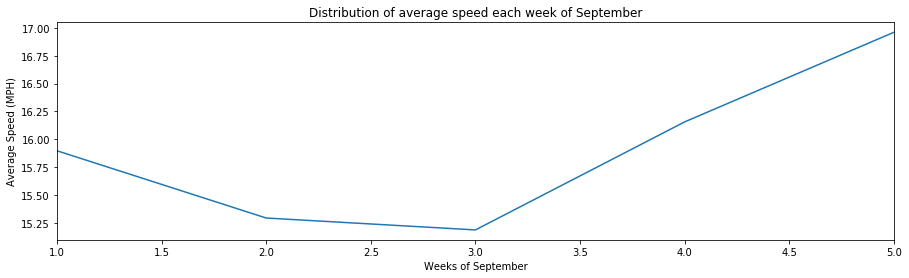

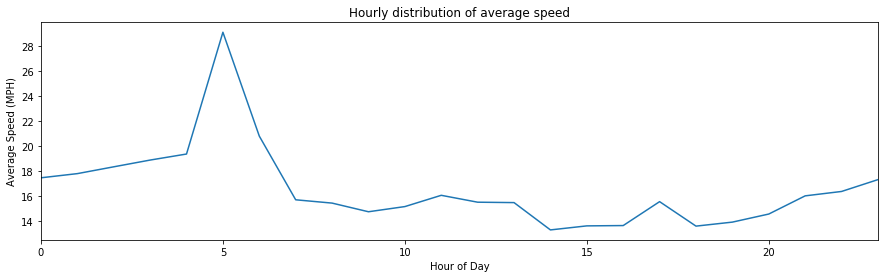

In [101]:
fig,ax = plot.subplots(1,1,figsize=(15,4))
week_Speed.columns = ['Week','Avg_Speed']
week_Speed.plot(ax=ax)
plot.ylabel('Average Speed (MPH)')
plot.xlabel('Weeks of September')
plot.title('Distribution of average speed each week of September')
plot.xlim([1,5])
plot.show()

fig,ax = plot.subplots(1,1,figsize=(15,4))
hour_Speed.columns = ['Hour','Avg_Speed']
hour_Speed.plot(ax=ax)
plot.ylabel('Average Speed (MPH)')
plot.xlabel('Hour of Day')
plot.title('Hourly distribution of average speed')
plot.xlim([0,23])
plot.show()

The speed in last two weeks of September is more than the first three weeks, we cannot hypothesize that the speed in last weeks is usually more unless we look at rest of the months but we can say that average speed varies with weeks. We can also see that speed varies per hour and the speed from 10 PM to 7 AM is much higher than the rest of the day. This can be because of the low traffic during these hours in NYC. Also, the speed between 5 AM to 6 AM is much higher.